© 2024 Nokia
Licensed under the BSD 3 Clause Clear License  
SPDX-License-Identifier: BSD-3-Clause-Clear

In [3]:
import numpy as np
import pandas as pd
import os
import re
import torch

from definitions import ROOT_DIR

In [4]:
os.chdir(ROOT_DIR)

In [5]:
x = pd.read_pickle('datasets\\GLOBEM\\x_all_globem.pkl')
y = pd.read_pickle('datasets\\GLOBEM\\y_all_globem.pkl')
ids = pd.read_pickle('datasets\\GLOBEM\\ids_all_globem.pkl')

In [6]:
print("Shapes\nx: {} - y: {} - ids: {}".format(x.shape, y.shape, ids.shape))
print("where 28 are the timesteps and 1390 are the features")

Shapes
x: (8122, 28, 1390) - y: (8122, 2) - ids: (8122,)
where 28 are the timesteps and 1390 are the features


# IDs exploration

In [5]:
def capture_PID(test_str, alt_regex=None):
    regex = r"(?:^INS-W_(\d+))" if not alt_regex else alt_regex
    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        return int(match.group(1))

In [6]:
ids = pd.DataFrame(ids)
ids.loc[:, 'pid'] = ids.iloc[:, 0].apply(lambda id: capture_PID(id))
alt_regex = r"(?:#INS-W_(\d+))"
ids.loc[:, 'year'] = ids.iloc[:, 0].apply(lambda id: capture_PID(id, alt_regex))
ids

,0,pid,year
0,INS-W_001#INS-W_1,1,1
1,INS-W_001#INS-W_1,1,1
2,INS-W_001#INS-W_1,1,1
3,INS-W_001#INS-W_1,1,1
4,INS-W_001#INS-W_1,1,1
...,...,...,...
8117,INS-W_999#INS-W_4,999,4
8118,INS-W_999#INS-W_4,999,4
8119,INS-W_999#INS-W_4,999,4
8120,INS-W_999#INS-W_4,999,4


In [7]:
ids.groupby('year')['pid'].nunique()

year
1    153
2    217
3    136
4    194
Name: pid, dtype: int64

In [8]:
print('Unique IDs in data: {}'.format(len(ids.pid.unique())))

Unique IDs in data: 700


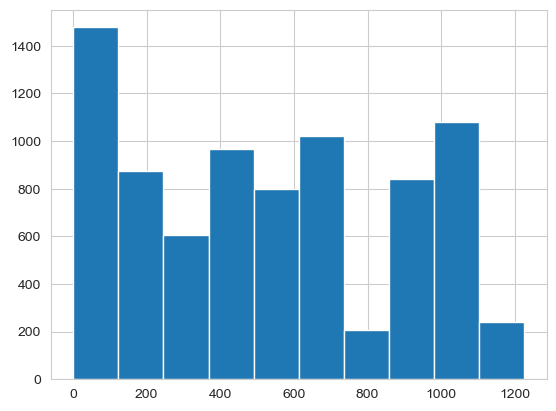

In [9]:
ids.pid.hist()

In [10]:
demographics = pd.read_csv(os.path.join('datasets', 'GLOBEM', 'demographics.csv'))
print(demographics.shape)
demographics

(838, 6)


,PID,gender,age,race,generation,disability
0,1,1.0,18.0,Asian,2.0,0.0
1,2,2.0,18.0,White,4.0,0.0
2,3,2.0,18.0,Biracial,4.0,0.0
3,4,2.0,18.0,Asian,2.0,0.0
4,5,2.0,18.0,Asian,2.0,0.0
...,...,...,...,...,...,...
833,1220,2.0,20.0,Asian,1.0,1.0
834,1221,1.0,21.0,Asian,1.0,1.0
835,1222,2.0,19.0,Asian,2.0,1.0
836,1223,3.0,18.0,Asian,2.0,1.0


Unique IDs in demographics list: 838


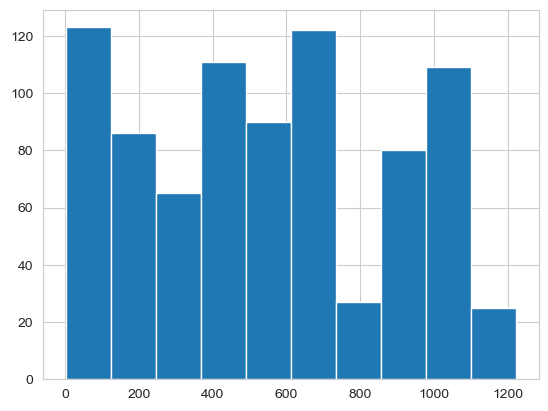

In [11]:
print('Unique IDs in demographics list: {}'.format(len(demographics.PID.unique())))
demographics.PID.hist()

In [12]:
print(demographics.age.mean())
print(demographics.age.std())

19.232974910394265
1.1644504486906617


In [55]:
merged_ids = demographics.merge(ids, left_on='PID', right_on='pid', how='right')
print('Unique IDs in data AND demographics list: {}'.format(merged_ids.PID.nunique()))

Unique IDs in data AND demographics list: 699


In [56]:
merged_ids.drop(columns=['pid', 0], inplace=True)
merged_ids

,PID,gender,age,race,generation,disability,year
0,1.0,1.0,18.0,Asian,2.0,0.0,1
1,1.0,1.0,18.0,Asian,2.0,0.0,1
2,1.0,1.0,18.0,Asian,2.0,0.0,1
3,1.0,1.0,18.0,Asian,2.0,0.0,1
4,1.0,1.0,18.0,Asian,2.0,0.0,1
...,...,...,...,...,...,...,...
8117,999.0,1.0,21.0,Asian,1.0,0.0,4
8118,999.0,1.0,21.0,Asian,1.0,0.0,4
8119,999.0,1.0,21.0,Asian,1.0,0.0,4
8120,999.0,1.0,21.0,Asian,1.0,0.0,4


# Train, Validation, Test Split

In [82]:
# to get more training data
train_rows = merged_ids.loc[merged_ids.year < 4, :].index
val_rows = merged_ids.loc[merged_ids.year == 4, :].index
# test_rows = merged_ids.loc[merged_ids.year == 4, :].index
test_rows = val_rows[int(len(val_rows)/2):]
val_rows = val_rows[:int(len(val_rows)/2)]

In [85]:
train_x = x[train_rows]
train_y = y[train_rows, 1]
train_ids = merged_ids.loc[train_rows, :]

val_x = x[val_rows]
val_y = y[val_rows, 1]
val_ids = merged_ids.loc[val_rows, :]

test_x = x[test_rows]
test_y = y[test_rows, 1]
test_ids = merged_ids.loc[test_rows, :]

In [86]:
print("Shapes")
print("Train x: {} y: {} ids: {}".format(train_x.shape, train_y.shape, train_ids.shape))
print("Validation x: {} y: {} ids: {}".format(val_x.shape, val_y.shape, val_ids.shape))
print("Test x: {} y: {} ids: {}".format(test_x.shape, test_y.shape, test_ids.shape))

Shapes
Train x: (5957, 28, 1390) y: (5957,) ids: (5957, 7)
Validation x: (1082, 28, 1390) y: (1082,) ids: (1082, 7)
Test x: (1083, 28, 1390) y: (1083,) ids: (1083, 7)


In [87]:
# TRAIN
train_samples = torch.from_numpy(train_x)
train_samples = torch.permute(train_samples, (0, 2, 1))  # permute to achieve order (samples, timesteps, channels)
train_labels = torch.from_numpy(train_y)
train_tensor = {'samples': train_samples, 'labels': train_labels}

# VAL
val_samples = torch.from_numpy(val_x)
val_samples = torch.permute(val_samples, (0, 2, 1))  # permute to achieve order (samples, timesteps, channels)
val_labels = torch.from_numpy(val_y)
val_tensor = {'samples': val_samples, 'labels': val_labels}

# TEST
test_samples = torch.from_numpy(test_x)
test_samples = torch.permute(test_samples, (0, 2, 1))  # permute to achieve order (samples, timesteps, channels)
test_labels = torch.from_numpy(test_y)
test_tensor = {'samples': test_samples, 'labels': test_labels}

In [88]:
# SAVE AS .PT
path = os.path.join("datasets", "GLOBEM")
torch.save(train_tensor, os.path.join(path, "train.pt"))
# torch.save(train_resampled_tensor, os.path.join(path, "train_resampled.pt"))
torch.save(val_tensor, os.path.join(path, "val.pt"))
torch.save(test_tensor, os.path.join(path, "test.pt"))

In [89]:
train_ids.to_csv(os.path.join(path, "train_listfile.csv"), index=False)
val_ids.to_csv(os.path.join(path, "val_listfile.csv"), index=False)
test_ids.to_csv(os.path.join(path, "test_listfile.csv"), index=False)